In [ ]:
# This file provide temple to train the model base on our own loss

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/My Drive/2023_fall/BA305/BA_305_Project/Process_data/3.train.csv")
df_test = pd.read_csv("/content/drive/My Drive/2023_fall/BA305/BA_305_Project/Process_data/3.test.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)
df_test.drop(columns=["Unnamed: 0"], inplace=True)

cost = np.array([[0,-900],[-100,400]])

Mounted at /content/drive


In [ ]:
X_train = df.drop(columns=['RainTomorrow'])
normalizer_X = StandardScaler()
normalizer_X.fit(X_train)
X_train = normalizer_X.fit_transform(X_train)
y_train = df['RainTomorrow']
y_train = y_train.values.ravel()

X_test = df_test.drop(columns=['RainTomorrow'])
X_test = normalizer_X.fit_transform(X_test)
y_test = df_test['RainTomorrow']
y_test = y_test.values.ravel()

In [ ]:
def custom_loss_func(y_actual,y_prob):
    y_pred_proba = np.array(y_prob)
    y = np.array(y_actual)
    thresholds = np.linspace(0, 1, 101)
    max_earn = -1000000
    cost = np.array([[0,-900],[-100,400]])
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(float)
        cons = confusion_matrix(y, y_pred)
        test_earn = np.sum(cons * cost)
        if test_earn > max_earn:
            max_earn = test_earn

    return max_earn

custom_scorer = make_scorer(custom_loss_func, greater_is_better=True, needs_proba=True) #response_method="predict_proba")

In [ ]:
param_grid = {
      "penalty":["l1", "l2", None],
      "class_weight":["balanced", None],
      "C": [0.5,1,2]
}

# Create the LR classifier
knn = LogisticRegression()

# Create the grid search
grid_search = GridSearchCV(knn, param_grid, scoring=custom_scorer, cv=5, n_jobs=-1,verbose=3)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('Best parameters:', best_params)
print('Best custom score:', best_score)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solve

Best parameters: {'C': 2, 'class_weight': None, 'penalty': 'l2'}
Best custom score: 46560.0


In [ ]:
# get the best parameters
best_penalty = grid_search.best_params_['penalty']
best_class_weight = grid_search.best_params_['class_weight']
best_C = grid_search.best_params_['C']

# train the model with best parameters
knn = LogisticRegression(penalty = best_penalty,
                         class_weight = best_class_weight,
                         C = best_C,)

knn.fit(X_train, y_train)

y_probs = knn.predict_proba(X_test)[:,1]

In [ ]:
net_val_vec = np.array([])

# Since grid search do not return the best threshhole, we need to find it manually.
thresholds = np.linspace(0, 1, 101)
for thresh_i in thresholds: #for loop
    # define new y_pred vector using custom threshold
    y_pred = np.where(y_probs >= thresh_i, 1, 0)
    # calculate the net value obtained
    cm = confusion_matrix(y_test, y_pred)
    net_val = np.sum(cm * cost)
    net_val_vec = np.append(net_val_vec, net_val)

max_val = np.amax(net_val_vec) # max value
max_val_idx = np.argmax(net_val_vec[::]) # index of max value (location)

print("Max value =", max_val, '|', " Best probability Threshold =", thresholds[max_val_idx])

Max value = 76600.0 |  Best probability Threshold = 0.71


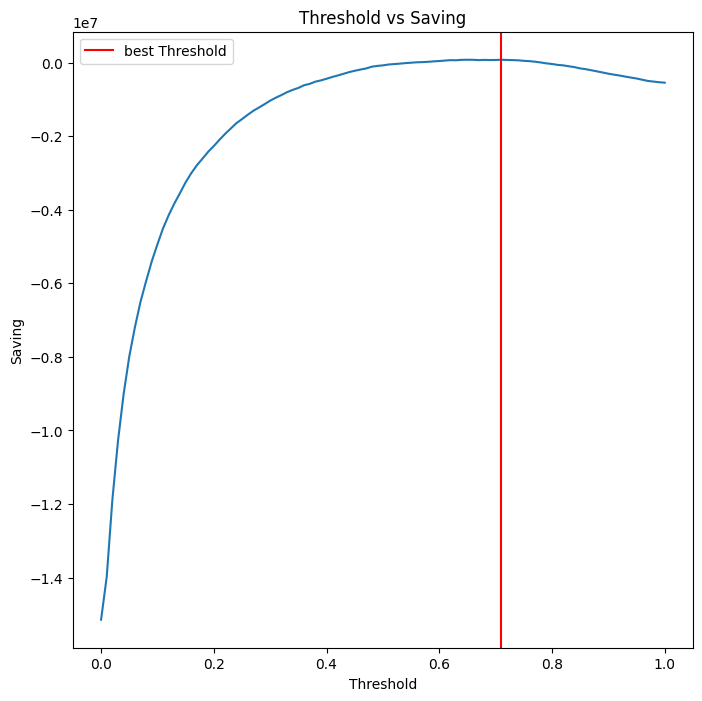

In [ ]:
fig,ax = plt.subplots(figsize=(8, 8))
plt.xlabel('Threshold')
plt.ylabel('Saving')
ax.set_title("Threshold vs Saving")
plt.plot(thresholds, net_val_vec)
plt.axvline(x = thresholds[max_val_idx], color = 'r', label = 'best Threshold')
plt.legend()
plt.show()

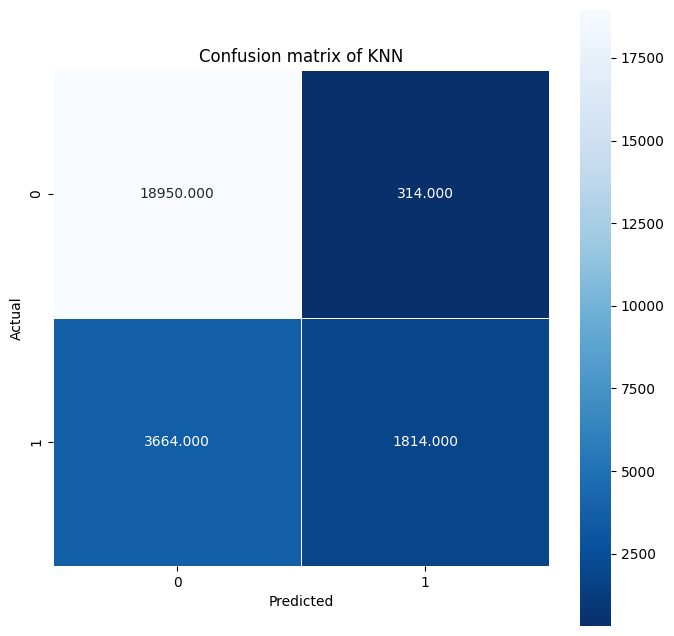

In [ ]:
# plot the confusion matrix
y_pred = np.where(y_probs >= thresholds[max_val_idx], 1, 0)
confusion_plot = confusion_matrix(y_test, y_pred)
fig,ax = plt.subplots(figsize=(8, 8))
ax.set_title("Confusion matrix of Logistic Regression")
sns.heatmap(confusion_plot, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', ax = ax)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# print the accuracy, precision, recall, f1-score
acc = (confusion_plot[0][0] + confusion_plot[1][1]) / (confusion_plot[0][0] + confusion_plot[1][1] + confusion_plot[0][1] + confusion_plot[1][0])
print("Accuracy: ", acc)
pre = confusion_plot[1][1] / (confusion_plot[1][1] + confusion_plot[0][1])
print("Precision: ", pre)
recall = confusion_plot[1][1] / (confusion_plot[1][1] + confusion_plot[1][0])
print("Recall: ", recall)
f1_score = 2 * pre * recall / (pre + recall)
print("F1-score: ", f1_score)

Accuracy:  0.8392207582248807
Precision:  0.8524436090225563
Recall:  0.33114275282949984
F1-score:  0.4769918485406259


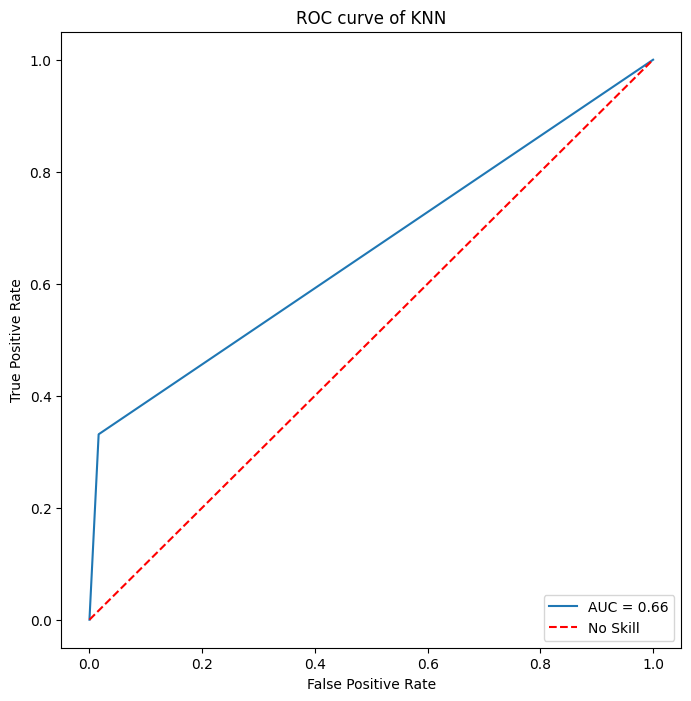

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
fig,ax = plt.subplots(figsize=(8, 8))
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title("ROC curve of KNN")
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--',label = 'No Skill')
plt.legend(loc = 'lower right')
plt.show()